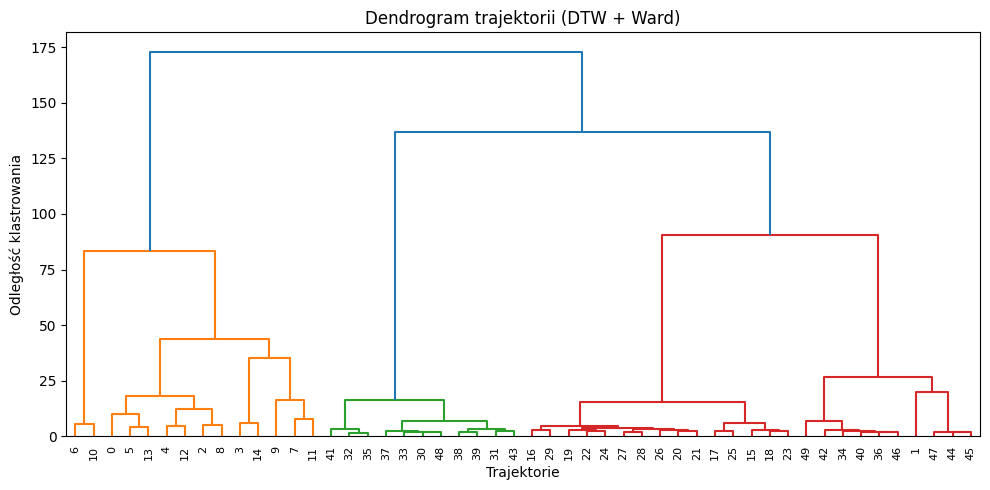

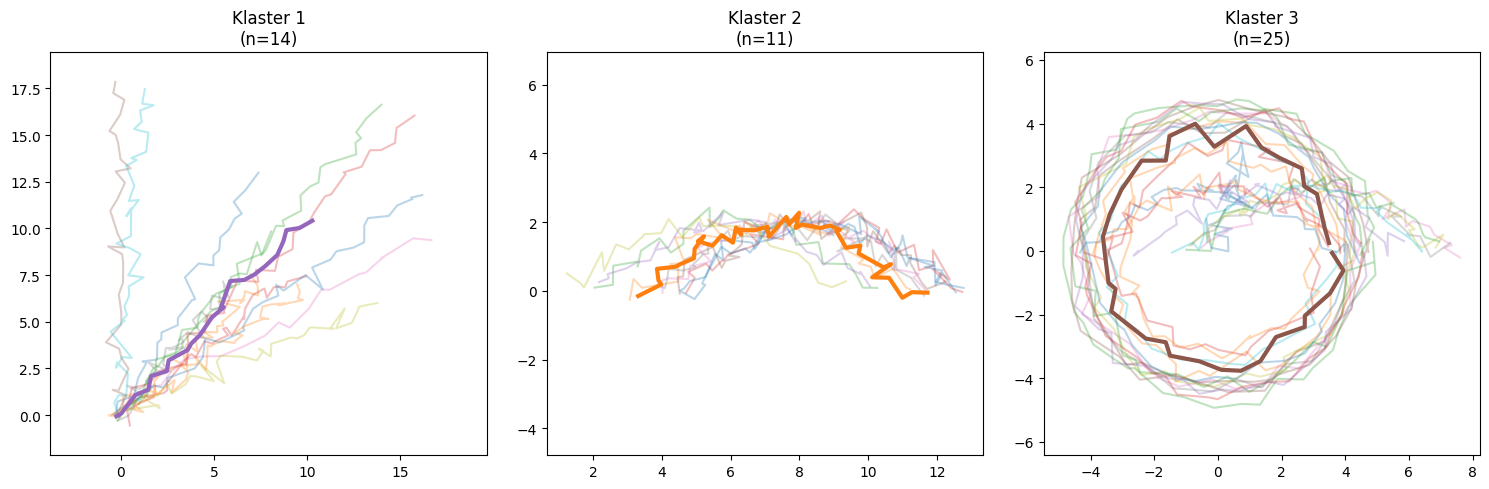

Odkryte klastry: [1 2 3]
Klaster 1: liczba trajektorii = 14
Klaster 2: liczba trajektorii = 11
Klaster 3: liczba trajektorii = 25


In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from dtaidistance import dtw_ndim



def generate_trajectories(n_trajectories=50, random_state=42):
    """Generuje syntetyczne trajektorie GPS."""
    np.random.seed(random_state)
    trajectories = []

    # Typ 1: Trasa do centrum (z różnych stron)
    for _ in range(15):
        length = np.random.randint(20, 40)
        start = np.random.randn(2) * 5 + [10, 10]
        end = np.array([0, 0])  # centrum
        t = np.linspace(0, 1, length).reshape(-1, 1)
        traj = start + t * (end - start) + np.random.randn(length, 2) * 0.3
        trajectories.append(traj)

    # Typ 2: Trasa rekreacyjna (pętla)
    for _ in range(15):
        length = np.random.randint(30, 50)
        t = np.linspace(0, 2 * np.pi, length)
        r = 3 + np.random.rand() * 2
        traj = np.column_stack([r * np.cos(t), r * np.sin(t)])
        traj += np.random.randn(length, 2) * 0.2
        trajectories.append(traj)

    # Typ 3: Trasa wzdłuż rzeki (liniowa)
    for _ in range(20):
        length = np.random.randint(25, 45)
        start_x = np.random.rand() * 10 - 5
        traj = np.column_stack([
            np.linspace(start_x, start_x + 8, length),
            np.sin(np.linspace(0, np.pi, length)) * 2
        ])
        traj += np.random.randn(length, 2) * 0.2
        trajectories.append(traj)

    return trajectories


def dtw_distance(traj1, traj2):
    traj1 = np.asarray(traj1, dtype=np.double)
    traj2 = np.asarray(traj2, dtype=np.double)
    return dtw_ndim.distance_fast(traj1, traj2)


def compute_dtw_matrix(trajectories):
    """Oblicza macierz odległości DTW."""
    n = len(trajectories)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = dtw_distance(trajectories[i], trajectories[j])
            D[i, j] = d
            D[j, i] = d
    return D


def plot_clusters(trajectories, D, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    plt.figure(figsize=(5 * n_clusters, 5))

    for k_idx, k in enumerate(unique_labels, start=1):
        idx = np.where(labels == k)[0]
        cluster_D = D[np.ix_(idx, idx)]
        mean_dist = cluster_D.mean(axis=1)
        medoid_local = np.argmin(mean_dist)
        medoid_idx = idx[medoid_local]

        plt.subplot(1, n_clusters, k_idx)
        for i in idx:
            traj = trajectories[i]
            plt.plot(traj[:, 0], traj[:, 1], alpha=0.3)
        rep = trajectories[medoid_idx]
        plt.plot(rep[:, 0], rep[:, 1], linewidth=3)
        plt.title(f"Klaster {k}\n(n={len(idx)})")
        plt.axis('equal')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    trajectories = generate_trajectories()

    D = compute_dtw_matrix(trajectories)

    condensed = squareform(D)
    Z = linkage(condensed, method='ward')

    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title("Dendrogram trajektori")
    plt.xlabel("Trajektorie")
    plt.ylabel("Odległość klastrowania")
    plt.tight_layout()
    plt.show()

    n_clusters = 3
    labels = fcluster(Z, n_clusters, criterion='maxclust')

    plot_clusters(trajectories, D, labels)

    unique_labels = np.unique(labels)
    print("Odkryte klastry:", unique_labels)
    for k in unique_labels:
        count = np.sum(labels == k)
        print(f"Klaster {k}: liczba trajektorii = {count}")
